# DETECTION DE PARCOURS TYPES DANS LE CENTRE EURALILLE

# 1. Contexte général:


* Clear Channel France est une régie publicitaire qui vends ses panneaux publicitaires aux annonceurs.


* Une campagne publicitaire est dite efficace si elle parvient à inciter les personnes exposées aux spots à aller se rendre dans les enseignes.   


* L'efficacité des campagnes peut être améliorée via l'analyse de flux afin de comprendre au mieux les habitudes des différentes catégories de la population.    




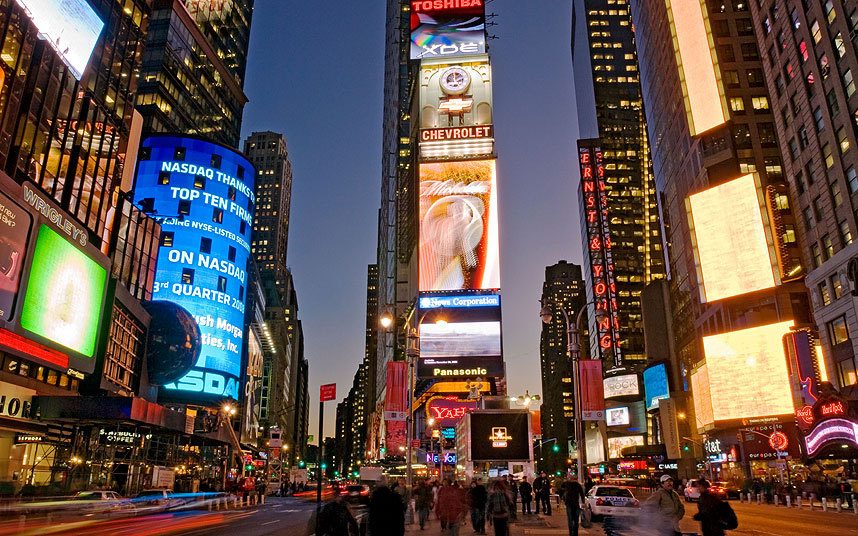


Nous abordons au cours de cette étude l'analyse des flux dans le centre commercial Euralille.




* Des capteurs type ***beacons*** sont installés dans les panneaux afin de tracker les déplacements des visiteurs dans le  centre.


* Un ***deviceID*** est attribué à chaque porteur de smartphone.


* Le croisement smartphone/beacon remonte une donnée incluant: deviceID, l'identifiant du beacon et l'instant de croisement. 




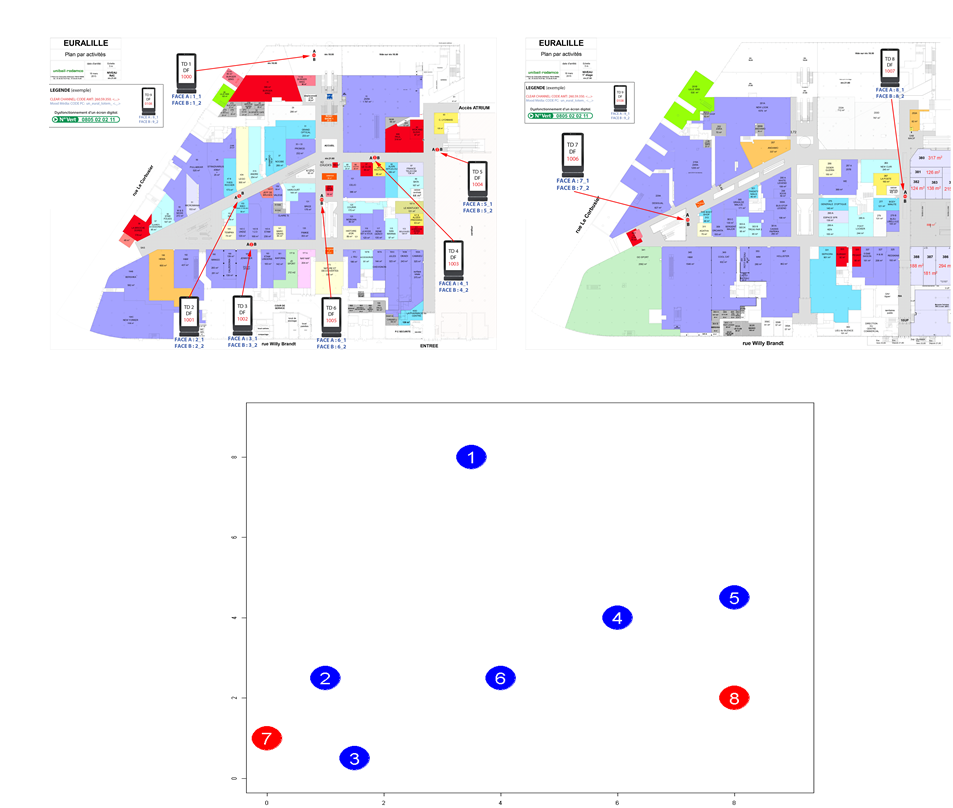

# 2. Problématique:

Repérer les parcours types des visiteurs afin de: 

* Mesurer les traffics;


* Trouver les ensembles de boutiques visitées les unes après les autres;


* Plannifier la diffusion de spot de sorte à augmenter l'exposition du passant au contenu de la publicité;





La méthodologie adoptée s'articule sur les étapes suivantes:




   * Mise en forme des données sous forme de séquences de panneaux associées à chaque DeviceId;


   * Netoyage des données en omettant les sous-séquences récurrentes ainsi que les très courtes séquences;


   * Définition d'une mesure de similarité permettant la comparaison de deux séquences de longueurs éventuellement différentes;


   * Application d'une classification hierarchique ascandante;


   * Sélection du nombre de classes et visualisation des parcours;



# 3. Méthodologie:




# 3.0 Installation de packages: 

Installer les packages suivants:

In [11]:
install.packages("chron")
install.packages("lubridate")
install.packages("igraph")
install.packages("network")


Warning message in install.packages("chron"):
“installation of package ‘chron’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message in install.packages("lubridate"):
“installation of package ‘lubridate’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message in install.packages("igraph"):
“installation of package ‘igraph’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Warning message in install.packages("network"):
“installation of package ‘network’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Les packages sont chargés avec:

In [10]:
suppressMessages(library(chron))
suppressMessages(library(lubridate))
suppressMessages(library(network))
suppressMessages(library(igraph))
library(readr)

ERROR: Error in library(chron): there is no package called ‘chron’


## 3.1 Formattage de données:

* Charger les données brutes depuis ***beaconData_2017-04-03To2017-04-30.csv*** puis rendre sous forme tabulaire;


* Associer pour chaque ligne un ***deviceId*** journalier; 


* La suite des panneaux croisés par un deviceId donné est décrite sur les différentes colonnes de la table; 

In [8]:
beaconData_2017_04_03To2017_04_30 <- read_delim("~/Documents/M2/innovation/beaconData_2017-04-03To2017-04-30.csv", 
                                                ";", escape_double = FALSE, trim_ws = TRUE)

Euralille_Totems_DistMatrix <- read_delim("~/Documents/M2/innovation/Euralille_Totems_DistMatrix.csv", 
                                          +     ";", escape_double = FALSE, col_names = FALSE, 
                                          +     trim_ws = TRUE)

beaconData=beaconData_2017_04_03To2017_04_30
Euralille=Euralille_Totems_DistMatrix

ERROR: Error in parse(text = x, srcfile = src): <text>:7:57: '=' inattendu(e)
6:                                           +     ";", escape_double = FALSE, col_names = FALSE, 
7:                                           +     trim_ws =
                                                           ^


In [9]:
print(beaconData[1:15,])


ERROR: Error in print(beaconData[1:15, ]): objet 'beaconData' introuvable


Définir la fonction *getPath(deviceId, beaconData)* permettant la construction de la table ***beaconData*** 

In [10]:
getPath <- function(deviceId, beaconData){

deviceIds = as.vector((beaconData[,"device_uid"])) 

extractedPoints = data.frame(beaconData[which(deviceIds == deviceId), c("Day", "Hour", "BeaconId")])

deviceIdPath = data.frame("Timestamp" = as.POSIXct(paste(as.character(as.Date
(strptime(extractedPoints[,"Day"], "%Y-%m-%d"))),extractedPoints[,"Hour"], sep = " "),tz = "GMT"), 
                          "Totem" = extractedPoints[,3])

return(deviceIdPath[order(deviceIdPath[,"Timestamp"]),] )

}

Ainsi, le parcours du *deviceId*     **9615467a7be2f180CB512BMU4S**  est obtenu avec

In [11]:
myPath = getPath("9615467a7be2f180CB512BMU4S", beaconData)
print(myPath[1:5,])

            Timestamp Totem
1 2017-04-03 08:42:55     6
2 2017-04-03 16:58:11     1
3 2017-04-04 17:39:15     5
4 2017-04-04 17:41:18     6
5 2017-04-05 16:39:05     5


Empaqueter *getPath(beaconData, deviceId)* dans la fonction *getDailySequences(beaconData)* pour obtenir les parcours de tous les deviceId compilés dans la table ***beaconData***. 

In [12]:
getDailySequences <- function(beaconData){

deviceIds = as.vector(unlist((beaconData[,"device_uid"]))) #"Advertising_Id"

uniqueIDs = unique(deviceIds)
print(paste("#Function getDailySequences: we found ", length(uniqueIDs), " unique IDs"))

#Calculer la longueur maximale + Nbr Séquences 
{
    seqLenthMax = 0 
    nbrSeqs = 0 

    for(i in (1:length(uniqueIDs))){

        #get the complete Path over different dates  
    ID = as.character(unlist(uniqueIDs[i]))
    # print(paste("# i = ", i,", deviceId = ", ID,"##################"))
    IDPath = getPath(ID, beaconData)

    #get unique dates
    allDates = as.Date(IDPath[,1])
    uniqueDates = unique(allDates)
    # print(uniqueDates)

    k = 1
    for(j in (1:length(uniqueDates))){

    pathByDay = c() #THE SEQUENCE OF VISITED TOTEMS PER DAY 


    while ((k <= length(allDates)) && (allDates[k] == uniqueDates[j])){

    pathByDay = c(pathByDay, as.numeric(as.character(IDPath[k,2])))
    k = k + 1
    }


    if(length(pathByDay)> seqLenthMax)
    seqLenthMax = length(pathByDay)

    nbrSeqs = nbrSeqs + 1 

    }

    }

print(paste("#Function getDailySequences: Longest path = ", seqLenthMax," Totems, Nbr Daily Paths = ", nbrSeqs))
}
    
dailySequences = data.frame("device_uid" = rep(NA, nbrSeqs), matrix(0, nbrSeqs, seqLenthMax*2))


seqIndex = 0 

for(i in (1:length(uniqueIDs))){

    #get the complete Path over different dates  
    ID = as.character(unlist(uniqueIDs[i]))
    # print(paste("# i = ", i,", deviceId = ", ID,"##################"))
    IDPath = getPath(ID, beaconData)

    #get unique dates
    allDates = as.Date(IDPath[,1])
    uniqueDates = unique(allDates)
    # print(uniqueDates)

    k = 1
    for(j in (1:length(uniqueDates))){

        pathByDay = c() #THE SEQUENCE OF VISITED (TOTEM,Timestamp)  PER DAY 

        while ((k <= length(allDates)) && (allDates[k] == uniqueDates[j])){

            pathByDay = c(pathByDay, as.numeric(as.character(IDPath[k,2])), (as.character(IDPath[k,1])) )

            k = k + 1
    }

    seqIndex = seqIndex + 1 
    dailySequences[seqIndex, 1] = paste(ID,"|",uniqueDates[j],sep = "")
    dailySequences[seqIndex, c(2:(length(pathByDay)+1))] = pathByDay 

    }

}

return(dailySequences)

}

Les colonnes de ***beaconData*** sont respectivement associées à: *DeviceId|Date, Panneau_1, timestamp_1,..., Panneau_m,timestamp_m* comme illustré ci-dessous


In [13]:
dailyPaths = getDailySequences(beaconData)
print(dailyPaths[1:5,1:10])


[1] "#Function getDailySequences: we found  1734  unique IDs"
[1] "#Function getDailySequences: Longest path =  436  Totems, Nbr Daily Paths =  2359"
                                       device_uid X1                  X2 X3
1 d9091ba0-3359-4a10-a910-e017abfd52f7|2017-04-03  2 2017-04-03 08:42:47  0
2           9615467a7be2f180CB512BMU4S|2017-04-03  6 2017-04-03 08:42:55  1
3           9615467a7be2f180CB512BMU4S|2017-04-04  5 2017-04-04 17:39:15  6
4           9615467a7be2f180CB512BMU4S|2017-04-05  5 2017-04-05 16:39:05  6
5           9615467a7be2f180CB512BMU4S|2017-04-06  6 2017-04-06 12:39:34  1
                   X4 X5                  X6 X7                  X8 X9
1                   0  0                   0  0                   0  0
2 2017-04-03 16:58:11  0                   0  0                   0  0
3 2017-04-04 17:41:18  0                   0  0                   0  0
4 2017-04-05 16:41:10  0                   0  0                   0  0
5 2017-04-06 12:41:36  5 2017-04-06 16:

## 3.2 Nettoyage de données


Eliminer avec la fonction *rmReccurSubSeq(dailySequences, timestamp)*  l'ensemble des sous-séquences récurrentes où *timestamp* est un booléen indiquant si on souhaite retenir les colonnes associées aux instants de croisements avec les panneaux.   

In [14]:
rmReccurSubSeq <- function(dailySequences, timestamp){


# dailySequences = dailyPaths_distincts

if(timestamp)
{

    #Maximum length of a distinct sequence 
    { 
    seqLengthMax_Dup = (ncol(dailySequences)-1)/2 
    dailySequences_Dup_geo = (data.matrix((dailySequences[,seq(2, 2*seqLengthMax_Dup, 2)])))
    colnames(dailySequences_Dup_geo) = paste("p", (1:seqLengthMax_Dup), sep = "")
    rownames(dailySequences_Dup_geo) = dailySequences[,1]
    dailySequences_Dup_ts = (data.frame((dailySequences[,seq(3, (2*seqLengthMax_Dup+1), 2)])))
    colnames(dailySequences_Dup_ts) = paste("t", (1:seqLengthMax_Dup), sep = "")
    seqLengthMax_Distinct = max(apply(dailySequences_Dup_geo, 1, function(x)   return(length(x[c(1,1 + which(diff(x) != 0))]))))
    }

    #Matrix Distinct Sequences 
    dailySequences_DISTINCT = matrix(0, nrow(dailySequences_Dup_geo) , (seqLengthMax_Distinct*2) + 1)
    dailySequences_DISTINCT[,1] = dailySequences[,1]

    for(i in (1:nrow(dailySequences_Dup_geo))){

        zeroIndex = which(dailySequences_Dup_geo[i,] == 0)
        mySeqSize = ifelse(length(zeroIndex)>0, zeroIndex[1]-1, length(dailySequences_Dup_geo[i,]))

        distinctTotemIndex = which(c(1,diff(as.numeric(dailySequences_Dup_geo[i,c(1:mySeqSize)]))) != 0)

        pathDistinct = dailySequences_Dup_geo[i,distinctTotemIndex]
        timestampsDistinct = dailySequences_Dup_ts[i,distinctTotemIndex]  

        seqSize = length(pathDistinct)
        seqDistinct_Index = seq(2,(2*seqSize)+1,2)

        for(j in (1:seqSize)){

            dailySequences_DISTINCT[i,seqDistinct_Index[j]+1] = as.character(timestampsDistinct[j])
            dailySequences_DISTINCT[i,seqDistinct_Index[j]] = as.character(pathDistinct[j])

        }


    }


return(dailySequences_DISTINCT)

} 
else 
{

            seqLengthMax_Dup = (ncol(dailySequences)-1)/2
            dailySequences_Dup_geo = (data.matrix((dailySequences[,seq(2, 2*seqLengthMax_Dup, 2)])))
            colnames(dailySequences_Dup_geo) = paste("p", (1:seqLengthMax_Dup), sep = "")
            rownames(dailySequences_Dup_geo) = dailySequences[,1]


            dailySequences_Dup_ts = (data.frame((dailySequences[,seq(3, (2*seqLengthMax_Dup+1), 2)])))
            colnames(dailySequences_Dup_ts) = paste("t", (1:seqLengthMax_Dup), sep = "")


            #Max Distinct Sequence Size 
            seqLengthMax_Distinct = max(apply(dailySequences_Dup_geo, 1, function(x)   return(length(x[c(1,1 + which(diff(x) != 0))])-1)))


            #Matrix Distinct Sequences 
            dailySequences_Distinct_geo = matrix(0, nrow(dailySequences_Dup_geo), seqLengthMax_Distinct)
            rownames(dailySequences_Distinct_geo) = dailySequences[,1]
            for(i in (1:nrow(dailySequences_Dup_geo))){

                pathDistinct = dailySequences_Dup_geo[i,][c(1,1 + which(diff(dailySequences_Dup_geo[i,]) != 0))]
                dailySequences_Distinct_geo[i, (1:(length(pathDistinct)-1))] = pathDistinct[(1:(length(pathDistinct)-1))]  

    }
return(dailySequences_Distinct_geo)
}

}


Dans le cadre de notre étude, nous nous affranchissons de la temporalité.  

In [15]:
dailyPaths_distinct = rmReccurSubSeq(dailyPaths, FALSE)
print(dailyPaths_distinct[1:5,1:4])

                                                [,1] [,2] [,3] [,4]
d9091ba0-3359-4a10-a910-e017abfd52f7|2017-04-03    2    0    0    0
9615467a7be2f180CB512BMU4S|2017-04-03              6    1    0    0
9615467a7be2f180CB512BMU4S|2017-04-04              5    6    0    0
9615467a7be2f180CB512BMU4S|2017-04-05              5    6    0    0
9615467a7be2f180CB512BMU4S|2017-04-06              6    1    5    6


Définir une fonction *filterPaths(dailyPaths, seqSizeMin, seqSizeMax, timestamp)* permettant de ne conserver que les parcours dont la taille est comprise entre *seqSizeMin* et *seqSizeMax*   

In [16]:
filterPaths <- function(dailyPaths, seqSizeMin, seqSizeMax, timestamp){

seqSizeMax = ifelse(!timestamp, min(seqSizeMax, ncol(dailyPaths)), min(seqSizeMax, as.integer(ncol(dailyPaths)/2))) 

seqSizeIndex = as.numeric(apply(dailyPaths, 1, function(x)   return(ifelse(length(which(x == 0))>0,(which(x == 0)[1])-1,length(x)))))

if(timestamp == FALSE)
    dailyPathsFiltered = dailyPaths[which((seqSizeIndex >= seqSizeMin) & (seqSizeIndex <= seqSizeMax)), c(1:seqSizeMax)]	
else 
    dailyPathsFiltered = dailyPaths[which((seqSizeIndex >= ((2*seqSizeMin) + 1) ) & (seqSizeIndex <= ((2*seqSizeMax) + 1 ) )), c(1:((2*seqSizeMax)+1))]


return(dailyPathsFiltered)

}

In [17]:
seqSizeMin = 2
seqSizeMax = 5 
dailyPaths_filt = filterPaths(dailyPaths_distinct, seqSizeMin, seqSizeMax, FALSE)
print(dailyPaths_filt[1:35,1:5])
print(nrow(dailyPaths_filt))


                                                      [,1] [,2] [,3] [,4] [,5]
9615467a7be2f180CB512BMU4S|2017-04-03                    6    1    0    0    0
9615467a7be2f180CB512BMU4S|2017-04-04                    5    6    0    0    0
9615467a7be2f180CB512BMU4S|2017-04-05                    5    6    0    0    0
9615467a7be2f180CB512BMU4S|2017-04-06                    6    1    5    6    0
9615467a7be2f180CB512BMU4S|2017-04-07                    5    4    0    0    0
9615467a7be2f180CB512BMU4S|2017-04-11                    6    5    4    0    0
9615467a7be2f180CB512BMU4S|2017-04-13                    5    2    3    1    0
9615467a7be2f180CB512BMU4S|2017-04-19                    6    5    1    6    0
9615467a7be2f180CB512BMU4S|2017-04-20                    5    4    0    0    0
9615467a7be2f180CB512BMU4S|2017-04-21                    6    5    6    0    0
9615467a7be2f180CB512BMU4S|2017-04-24                    6    1    0    0    0
9615467a7be2f180CB512BMU4S|2017-04-25               

## 3.3 Similarité entre parcours
###  Placement des panneaux dans le centre: 

Un graphe est associé au plan du centre commercial Euralille où:

   * un nœud peut représenter un panneau publicitaire ou un croisement de couloirs;
    
    
   * une arête représente le bout de couloir en mètres raccordant les i-ème intersections/panneaux aux j-ème intersections/panneaux;






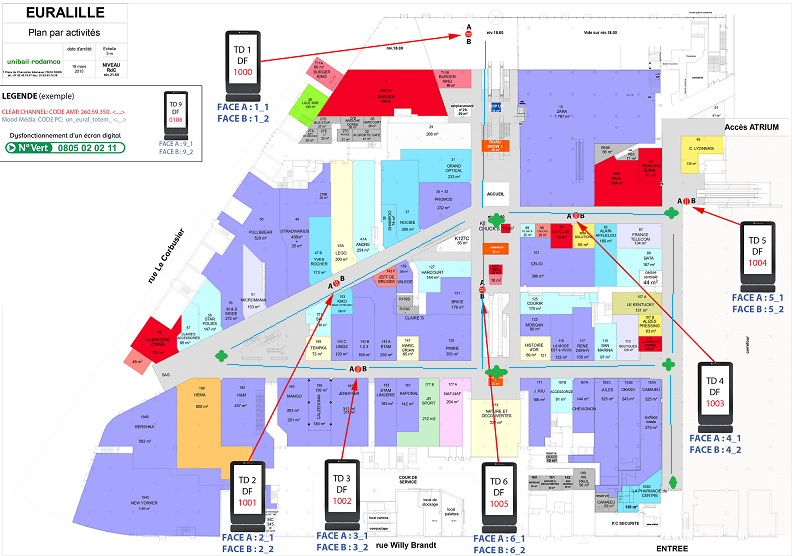

* Le graphe Euralille est composé de 25 nœuds (panneaux + intersections). 



* La matrice d'adjacence du graphe est notée **M** et est définie dans *Euralille_Totems_DistMatrix.csv*.



* Les $8$ premières lignes et colonnes de **M** sont associées aux $8$ panneaux publicitaires. 



* Soit *i,j* deux nœuds donnés, **M[i,j]** représente le nombre de mètres entre  *i* et *j* s'il existe un chemin direct les raccordant, **M[i,j]** = 1000000 sinon.



* La matrice **P** est définie uniquement sur les panneaux telle que **P[i,j]** = plus court chemin entre *i* et *j* selon l'algorithme de [Dijkstra](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm).



* La matrice **P** est calculée avec la fonction *getTotemDistMat()* 


In [15]:
getTotemDistMat <- function(){

distMatPath = paste(projectPath,"Data\\Euralille_Totems_DistMatrix.csv", sep = "")

mallDistMatrix = as.matrix(read.table(distMatPath, sep = ";"))
colnames(mallDistMatrix) = c(1:nrow(mallDistMatrix))
rownames(mallDistMatrix) = c(1:nrow(mallDistMatrix))

infDist = max(mallDistMatrix)
mallGraph = graph_from_adjacency_matrix(mallDistMatrix, "directed", TRUE)

#Calcul des distances associées aux plus courts chemins entre les totems du mall 
nbrTotems = 8 

mallTotemDistMatrix = matrix(infDist, nbrTotems, nbrTotems)
diag(mallTotemDistMatrix) = 0
colnames(mallTotemDistMatrix) = c(1:nbrTotems)
rownames(mallTotemDistMatrix) = c(1:nbrTotems)

for(From in (1:nbrTotems))
    for(To in (1:nbrTotems))
            if(From != To){

                shortestPath_Dist = 0 
                shortestPath = as.numeric((unlist(shortest_paths(mallGraph, From, To ,"all"))))

                for(i in (1:(length(shortestPath)-1)))
                    shortestPath_Dist = shortestPath_Dist + mallDistMatrix[shortestPath[i], shortestPath[(i+1)]]

                mallTotemDistMatrix[From, To] = shortestPath_Dist	

    }

return(mallTotemDistMatrix)

}

In [16]:
mallTotemDistMatrix = getTotemDistMat()
print("Les distances entre les 8 panneaux dans Euralille sont:")
print(mallTotemDistMatrix)

[1] "Les distances entre les 8 panneaux dans Euralille sont:"
    1   2   3   4   5   6   7   8
1   0 115 160  95 134  85 163 154
2 115   0 120  90 130  80 100 160
3 160 120   0 135 163  75 100 138
4  95  90 135   0  40  60 178  70
5 134 130 163  40   0 100 151  30
6  85  80  75  60 100   0 118 123
7 163 100 100 178 151 118   0 171
8 154 160 138  70  30 123 171   0


### Similarité entre les parcours:

* Soient $\textbf{A}, \textbf{B}$ deux suites de panneaux associées à deux *deviceId* distincts respectivement de longueurs $n_A, n_B > 0$.


* On définit la plus longue sous-séquence commune $LCS(\textbf{A},\text{B})$ comme étant la suite de panneaux commune $\textbf{S}$ de taille $n_S$.


* Il est à noter que la sous-séquence $\textbf{S}$  peut être intérrompue dans $\textbf{A}$ ou dans $\textbf{B}$ par des panneaux non communs. 


* Exemple: $\textbf{S} = \{1,5,4\}$ est la sous-séquence commune entre $\textbf{A} = \{1,5,4\}$ et $\textbf{B} = \{1,2,5,3,4\}$.


* La fonction $LCS(\textbf{A}, \textbf{B})$ est définie récursivement telle que

    \begin{cases}
    LCS({X_{i-1}}, Y_{j-1}) \cap x_i & \mbox{ Si } x_i = y_i\\
    & \\
    longest(LCS(X_i,Y_{j-1}), LCS(X_{i-1},Y_j)) & \mbox{ Si } x_i \neq y_j \\
    & \\
    \emptyset & \mbox{ Si } i = 0 \mbox{ ou } j = 0 
    \end{cases}



* La fonction *LCSS_Totem(A,B, delta, epsilon, mallTotemDistMatrix)* retourne $n_s$ la taille de $\textbf{S}$ calculée par $LCS(\textbf{A}, \textbf{B})$ où *epsilon* représente le seuil de mètres à partir duquel les panneaux peuvent être confondu. Le paramètre *delta* est la taille de la plus longue séquence.   


In [17]:
LCSS_Totem <- function(A,B, delta, epsilon, mallTotemDistMatrix){

if((length(A) == 0) | (length(B) == 0)){
    # print("EMPTY SEQUENCE CASE!")
    return(0)
} else 
            if ( (mallTotemDistMatrix[A[length(A)],B[length(B)]] <= epsilon[1]) && (abs(length(A)-length(B)+1) <= delta)	#BEWARE OF THE + 1 >< 	
            ){

                    # print("MATCHING CASE!")
                    return(1 + LCSS_Totem(A[-length(A)], B[-length(B)], delta, epsilon, mallTotemDistMatrix))
              }
                    else{
                    # print(paste("MAX CASE! nrow(A) = ",length(A),", nrow(B) = ",length(B)))
                    return(max
                                (
                                LCSS_Totem(A[-length(A)], B, delta, epsilon, mallTotemDistMatrix),
                                LCSS_Totem(A, B[-length(B)], delta, epsilon, mallTotemDistMatrix)
                                )  

    )

    }

}

In [18]:
A = c(1,5,4)
B = c(1,2,5,3,4)
mallTotemDistMatrix = getTotemDistMat()
LCSSSize = LCSS_Totem(A,B, max(length(A),length(B)), 0, mallTotemDistMatrix)
print(paste("La taille de la sous-séquence commune entre A et B = ", LCSSSize, sep = ""))

[1] "La taille de la sous-séquence commune entre A et B = 3"


La taille $n_s$ est transformée en similarité avec 
    \begin{equation}
    \frac{n_s}{\mbox{min}(n_A,n_B)} \in [0,1]
    \end{equation}
        
La matrice de similarités entre les séquences de la table *dailyPaths_filt* est obtenue avec les deux fonctions suivantes         

In [19]:
dist_geoLCSS <- function(path1, path2, delta, epsilon, mallTotemDistMatrix){

zeroIndex = which(path1 == 0)
if(length(zeroIndex) == 0)
    size1 = length(path1) else 
    size1 = zeroIndex[1]-1

zeroIndex = which(path2 == 0)
    if(length(zeroIndex) == 0)
    size2 = length(path2) else 
    size2 = zeroIndex[1]-1

return(LCSS_Totem(path1[1:size1],path2[1:size2], delta, epsilon, mallTotemDistMatrix)/min(size1,size2))

}
getDistMatLCSS <- function(dailyPaths, epsilon, mallTotemDistMatrix){

cat("#getDistMatLCSS: Computation of the Matrix of distances LCSS\n")

nObs = nrow(dailyPaths)

dailyPaths_DIST_MATRIX = matrix(1, nObs, nObs)
dailyPathsRowNames = rownames(dailyPaths)
rownames(dailyPaths_DIST_MATRIX) = dailyPathsRowNames
colnames(dailyPaths_DIST_MATRIX) = dailyPathsRowNames


for(i in (1:nObs)){
    cat(paste("processing ", dailyPathsRowNames[i], " (",i,"/",nObs,")...\n", sep = ""))

    for(j in (i:nObs))
        if(i != j){
        # print(paste("distance between ",i," and ", j))
        dailyPaths_DIST_MATRIX[i,j] = dist_geoLCSS(dailyPaths [i,], dailyPaths [j,], max(length(dailyPaths [i,]), length(dailyPaths [j,])), epsilon, mallTotemDistMatrix)
            dailyPaths_DIST_MATRIX[j,i] = dailyPaths_DIST_MATRIX[i,j]
    }
}

return(dailyPaths_DIST_MATRIX)
}


In [21]:
seqSizeMin = 2
seqSizeMax = 5 
dailyPaths_filt = filterPaths(dailyPaths_distinct, seqSizeMin, pseqSizeMax, FALSE)
distMatLCSS = getDistMatLCSS(dailyPaths_filt, 0, mallTotemDistMatrix)

#getDistMatLCSS: Computation of the Matrix of distances LCSS
processing 9615467a7be2f180CB512BMU4S|2017-04-03 (1/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-04 (2/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-05 (3/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-06 (4/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-07 (5/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-11 (6/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-13 (7/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-19 (8/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-20 (9/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-21 (10/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-24 (11/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-25 (12/838)...
processing 9615467a7be2f180CB512BMU4S|2017-04-28 (13/838)...
processing B4S-1-CCFC6EA3-D176-490A-9722-CBD891A675A2|2017-04-10 (14/838)...
processing B4S-1-CCFC6EA3-D176-490A-9722-CBD891A675A2|2017-04-13 (15/838)...
p

## 3.4 Clustering des parcours

* Application de la Classification Ascandante Hierarchique sur la matrice de similarités *distMatLCSS*; 


* Afficher le dendrogramme associé;


* Désigner le nombre de parcours types dans le centre Euralille et les identifier;



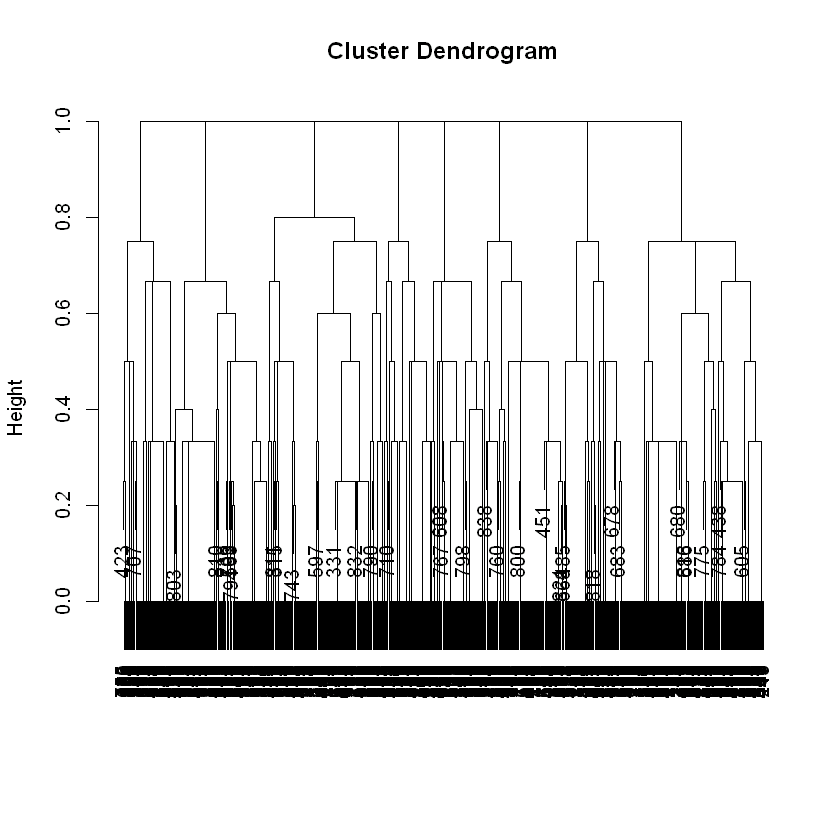

In [22]:
clusSequences = hclust(as.dist(1-distMatLCSS), "complete")
clusSequences$labels = (1:length(clusSequences$labels)) #rename the obs (IDFA + Date is unreadable ><)  
X11()
plot(clusSequences, xlab = "", sub = "")


 

## 3.5 Visualisation de la Classification

Visualiser les prototypes associés à chacune des classes de parcours dans le centre Euralille.

In [23]:
nbrClus = 8

vizCluster <- function(i){

dailyPaths_Clusters = as.vector(unlist(cutree(clusSequences, nbrClus)))
dailyPaths =  dailyPaths_filt 

totemCoords = matrix(c( 3.5,8,#1
                        1,2.5,#2
                        1.5,0.5,#3
                        6,4,#4
                        8,4.5,#5
                        4,2.5,#6
                        0,1,#7
                        8,2)#8
                        ,8,2, byrow = TRUE)   
    
        clusIndices = which(dailyPaths_Clusters == i)
        if(length(clusIndices) == 1)
            clusterData = t(dailyPaths[which(dailyPaths_Clusters == i), (1:(ncol(dailyPaths)))]) 
        else 
            clusterData = dailyPaths[which(dailyPaths_Clusters == i), ]

        cluster_i_Pourcentage = as.numeric(format((nrow(clusterData)/length(dailyPaths_Clusters))*100, digits = 2))	

        #Draw the graph
        plot(type = "p", totemCoords, col = c(rep("blue", 6),rep("red", 2)), pch = 19, cex = 10, xlim = c(0,max(totemCoords)+1), ylim = c(0,max(totemCoords)+1), xlab = "", ylab = "", main = paste("Cluster ", i,": ",  cluster_i_Pourcentage,"% of paths", sep = "" ))
        text(totemCoords[,1],totemCoords[,2], c(1:nrow(totemCoords)), col = "white", cex = 3)
                #Add the steps 
                varRow = 0.01
                for(l in (1:nrow(clusterData))){

                    proto_i = clusterData[l,]
                    zeroIndex = which(proto_i == 0)
                    mySeqSize = ifelse(length(zeroIndex)>0, zeroIndex[1]-1, length(proto_i))

                    for(s in (1:(mySeqSize-1))){
                        arrows(totemCoords[proto_i[s],1]+rnorm(1,0,varRow),totemCoords[proto_i[s],2]+rnorm(1,0,varRow),
                        totemCoords[proto_i[s+1],1]+rnorm(1,0,varRow),totemCoords[proto_i[s+1],2]+rnorm(1,0,varRow),
                        lwd = 1,col = "black")

                    }
                }

}

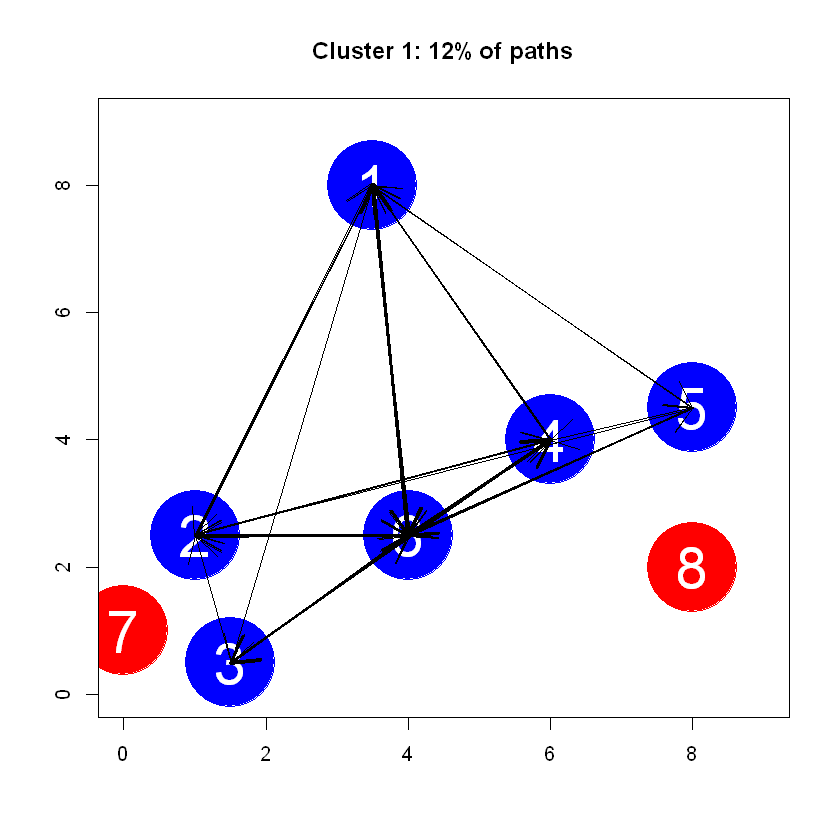

In [24]:
vizCluster(1)

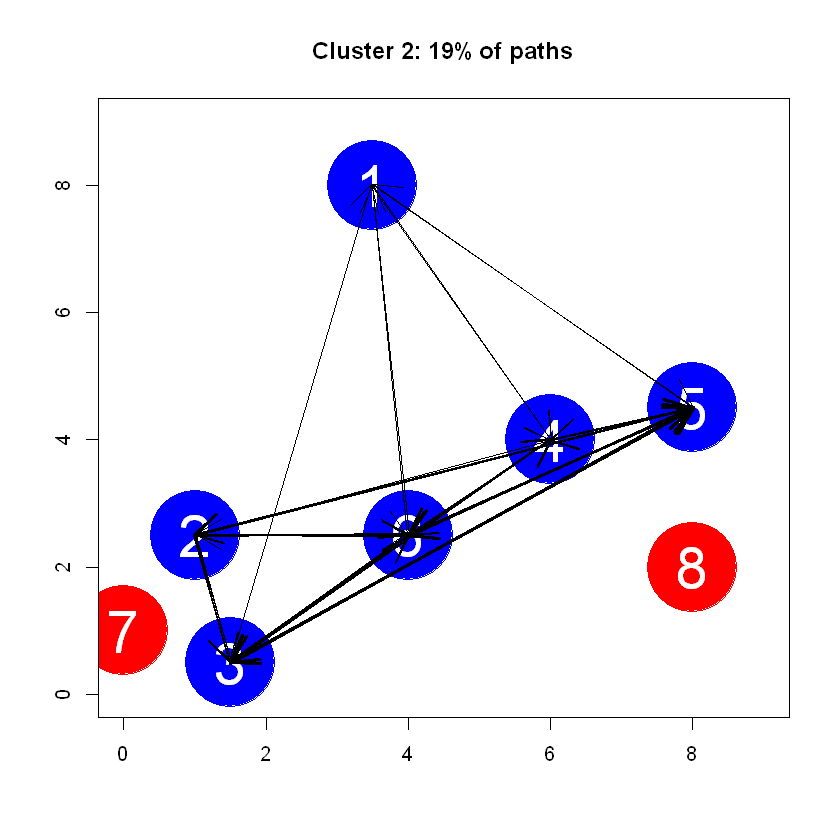

In [24]:
vizCluster(2)

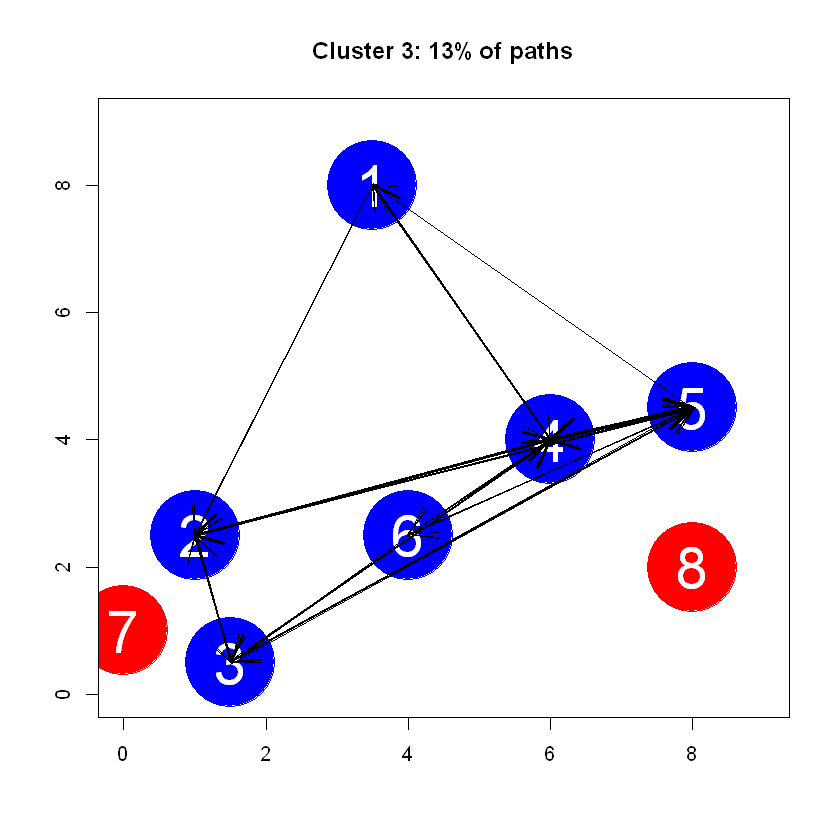

In [25]:
vizCluster(3)

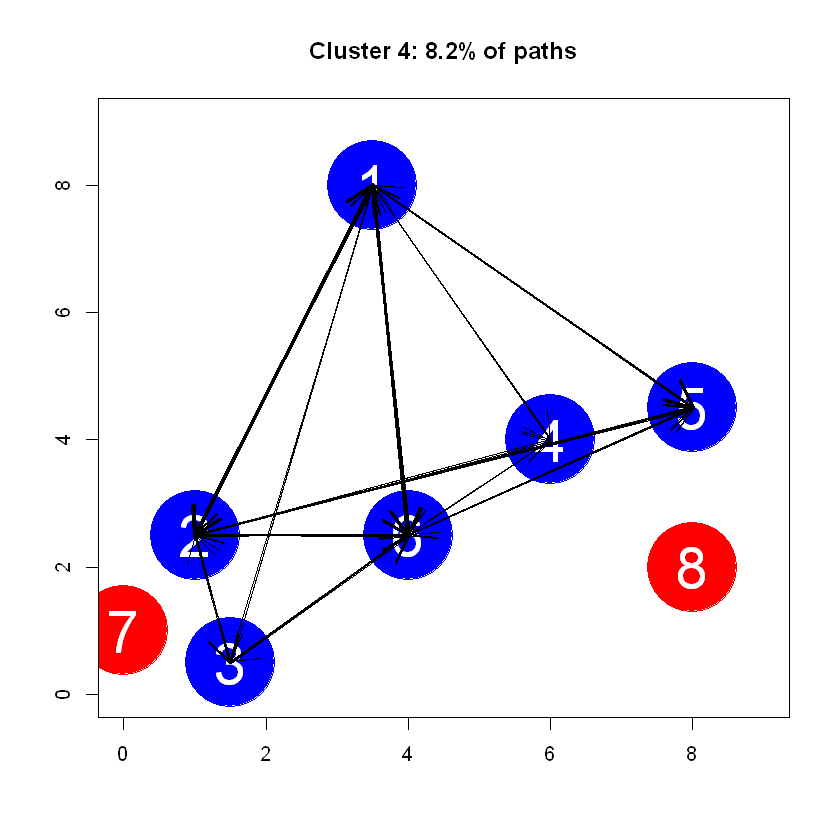

In [26]:
vizCluster(4)

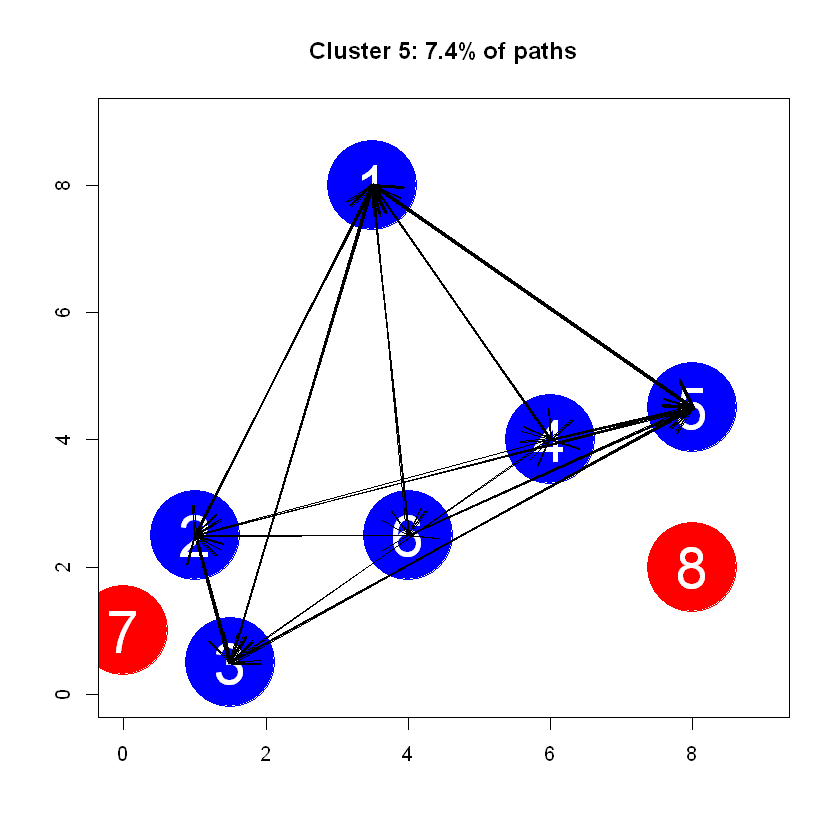

In [36]:
vizCluster(5)

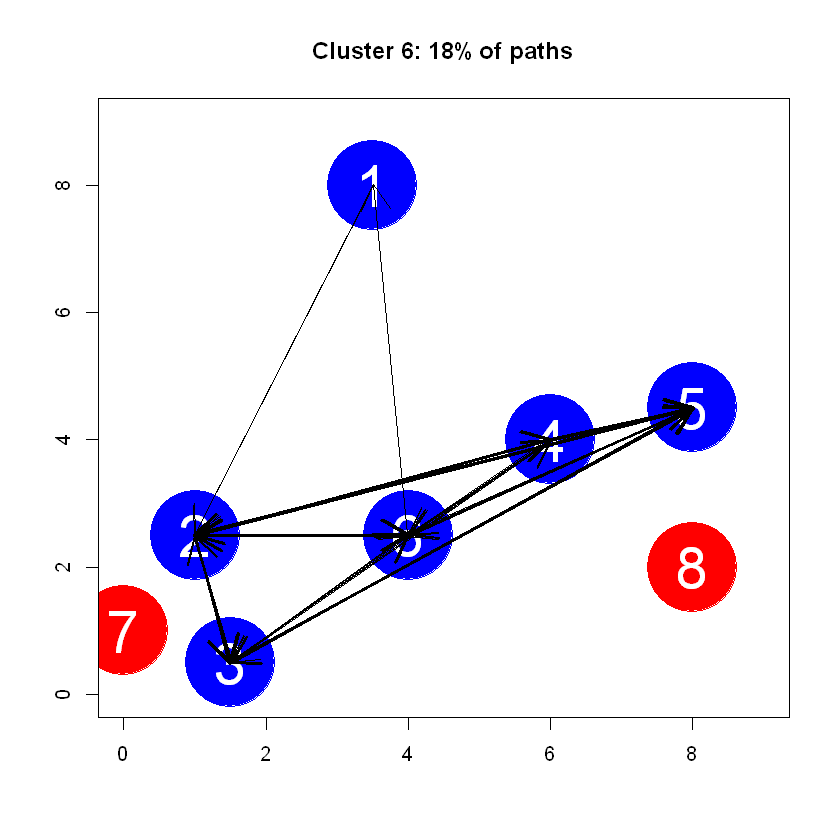

In [27]:
vizCluster(6)

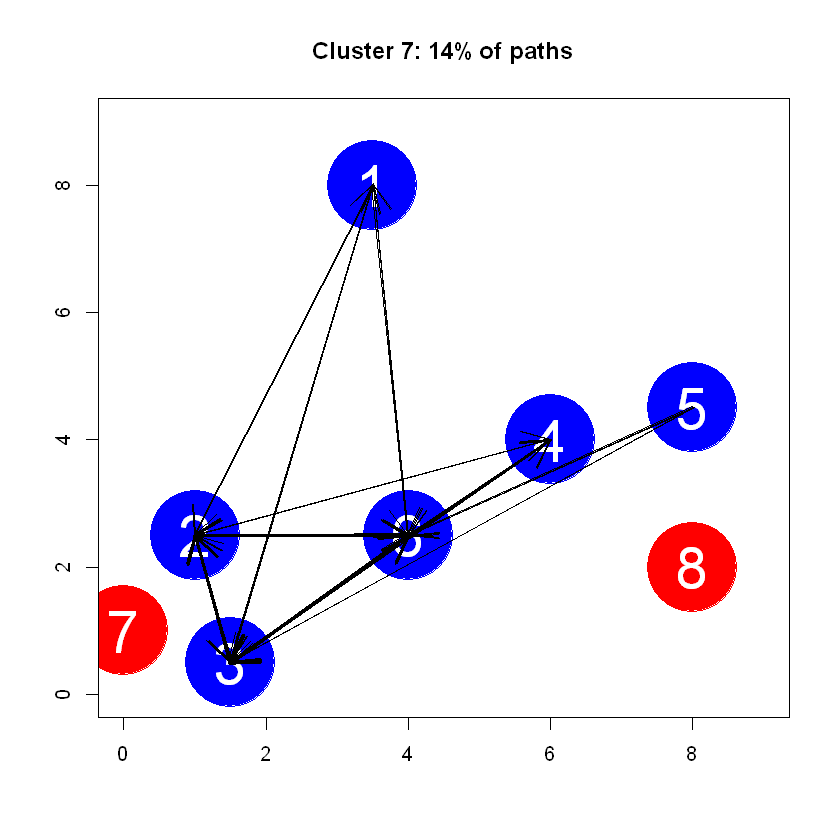

In [28]:
vizCluster(7)

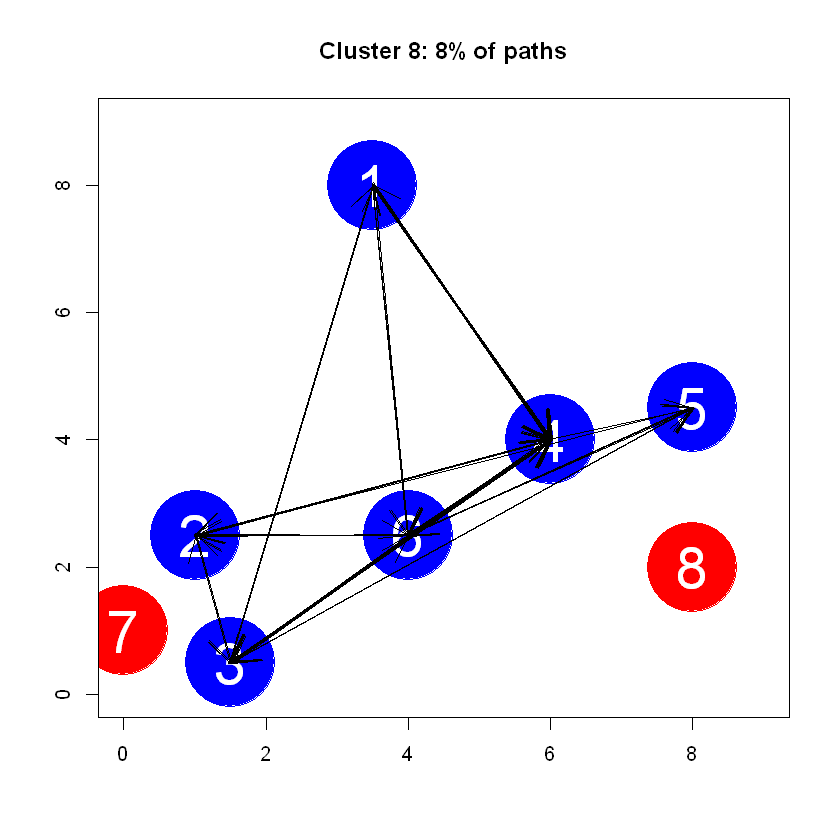

In [29]:
vizCluster(8)

In [1]:
print("prout")

[1] "prout"
